In [24]:
# Grad-CAM Explainability for Satellite Imagery
#This notebook visualizes which regions of satellite images influence the CNN feature extractor.

In [25]:
import os
import sys
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
)
model.eval()
model.to(device)

target_layer = model.layer4

In [27]:
image_dir = "../data/images/train"
image_path = os.path.join(image_dir, os.listdir(image_dir)[0])

raw_image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

input_tensor = transform(raw_image).unsqueeze(0).to(device)

In [28]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()
        output = self.model(input_tensor)
        class_idx = output.argmax(dim=1).item()
        score = output[:, class_idx]
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)

        cam = cam.squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

In [29]:
gradcam = GradCAM(model, target_layer)
cam = gradcam.generate(input_tensor)

c:\Users\rushi\real-estate-multimodal-regression\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


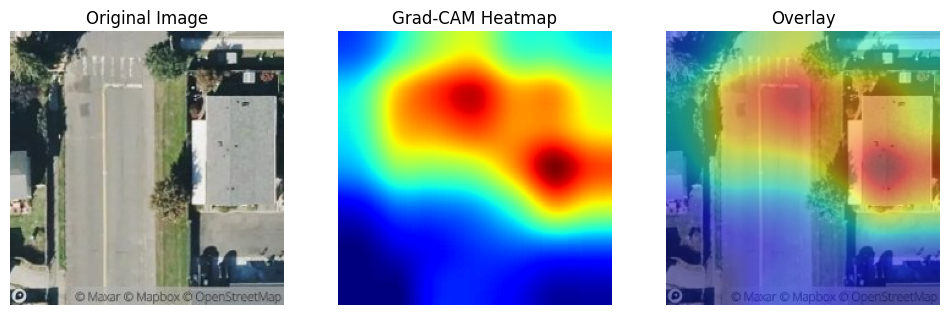

In [30]:
cam_resized = Image.fromarray((cam * 255).astype(np.uint8)).resize(raw_image.size)
cam_resized = np.array(cam_resized)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(raw_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cam_resized, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(raw_image)
plt.imshow(cam_resized, cmap="jet", alpha=0.5)
plt.title("Overlay")
plt.axis("off")

plt.show()